# From kernel string to structure drawing

### Thought process
First, count domains and create a table that has nrow corresponding to dom. count. As the string is very systematic, with a regional expression I can separate the domains with all their information given.  
The good thing here is that the sequence of domains is clear from the string.  
Most important is to know which domain is paired with which. As a human, when I find a bracket in the string, I look for its counterpart. This will have to be done in the second step and put the pairing info into a dictionary(?).

In [1]:
import numpy as np
import re
import networkx as nx
from matplotlib import pyplot as plt

Angle: [-179, 180]

In [2]:
#error handling step 1
def check_string_valid(string):
    if re.search("[$ß€]", string): #all special characters?
        raise Exception("bad string")
        
#check_string_valid("@90 a ß90 b")

In [3]:
string = '@90 a( B + ) @45 e* f1'
re.findall('@?[0-9]* ?[a-z|A-Z|0-9|\*]+[ \(]?\+?|\)', string)

['@90 a(', ' B +', ')', '@45 e* ', 'f1']

table(int) - cols: angle before dom, length, dom type?, if there is a strand break after  
dictionary - pairedness  
list of list - name of domains, their preliminary type 

In [4]:
def comprehend_string(string):
    #separate domains/count
    pattern = re.compile('@?-?[0-9]* ?[a-z|A-Z|0-9|\*]+[ \(]? ?\+?|\) ?\+?')
    dom_raw_list = pattern.findall(string)
    dom_count = len(dom_raw_list)
        
    #create empty data structures     
    struct_info_array = np.zeros((dom_count, 4), dtype = 'int') #4 cols rn
    name_list1 = []
    
    #loop through the raw domains, extract  
    for dom_i in range(len(dom_raw_list)):
        dom = dom_raw_list[dom_i]
        dom = dom.strip()
        
        #fill table
        if re.search("\s", dom):
            dom_parts = re.split("\s", dom)
            
            for segm in dom_parts:
                if segm[0] is "@": #col0 angle
                    segm = segm.lstrip("@")
                    struct_info_array[dom_i, 0] = int(segm) #col0 to write to
                    struct_info_array[dom_i, 1] = np.sign(int(segm)) #col1 to write to
                    
                elif segm is "+": #col2 strand break
                    struct_info_array[dom_i, 2] = 1         #col2 to write to
                else:
                    name_list1.append(segm) #only keep the name part further
        else:
            name_list1.append(dom)
        
    #pairedness dictionary
    paired_dict = {}
    
    for dom_i2 in range(len(dom_raw_list)):
        if re.search("\(", dom_raw_list[dom_i2]):
            bracket_count = 1
            for next_dom in range(dom_i2+1, len(dom_raw_list)):
                if re.search("\(", dom_raw_list[next_dom]):
                    bracket_count += 1
                elif re.search("\)", dom_raw_list[next_dom]):
                    bracket_count -= 1
                if bracket_count == 0:
                    paired_dict[dom_i2] = next_dom
                    break
    
    #name list of list / finding hairpin loops
    #paireds in dict, hairpin loop known, other are unpaired -> substructure from these?
    name_final_lol = []
    
    for dom_i3 in range(len(name_list1)):
        
        #paireds
        if re.search("\(", name_list1[dom_i3]):
            typ = "paired"
            name = name_list1[dom_i3].strip("(+ ")
        
        #correcting closing bracket name
        elif re.search("\)", name_list1[dom_i3]):
            typ = "paired"
            index_of_pair = list(paired_dict.keys())[list(paired_dict.values()).index(dom_i3)]
            if re.search("\*", name_list1[index_of_pair]):
                name = name_list1[index_of_pair].strip("\(").strip("\*")
            else:
                name = name_list1[index_of_pair].strip("\(") + "*"
        
        #all other are unpaireds
        else:
            typ = "unpaired"
            name = name_list1[dom_i3].strip("+ ")
        
        name_final_lol.append([name, typ])
        
    return dom_raw_list, struct_info_array, paired_dict, name_final_lol

In [5]:
string = "@-45 d1S T2 @-135 b( a( t2( + ) ) c*( t1* + ) )"
comprehend_string(string)[1:4]

(array([[ -45,   -1,    0,    0],
        [   0,    0,    0,    0],
        [-135,   -1,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    1,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    1,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]]),
 {2: 10, 3: 6, 4: 5, 7: 9},
 [['d1S', 'unpaired'],
  ['T2', 'unpaired'],
  ['b', 'paired'],
  ['a', 'paired'],
  ['t2', 'paired'],
  ['t2*', 'paired'],
  ['a*', 'paired'],
  ['c*', 'paired'],
  ['t1*', 'unpaired'],
  ['c', 'paired'],
  ['b*', 'paired']])

In [6]:
string2 = "t1( c( a( + t2* ) b*( d2 t3 + ) ) )"
comprehend_string(string2)[1:4]

(array([[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]),
 {0: 10, 1: 9, 2: 4, 5: 8},
 [['t1', 'paired'],
  ['c', 'paired'],
  ['a', 'paired'],
  ['t2*', 'unpaired'],
  ['a*', 'paired'],
  ['b*', 'paired'],
  ['d2', 'unpaired'],
  ['t3', 'unpaired'],
  ['b', 'paired'],
  ['c*', 'paired'],
  ['t1*', 'paired']])

In [7]:
string3 = "@-90 aa( @-135 i1 @-90 da( dl ) @-135 i2 @-90 aca( acl ) @-135 vr @-135 pa( pl ) @-135 i3 ) @0 c"
comprehend_string(string3)[1:4]

(array([[ -90,   -1,    0,    0],
        [-135,   -1,    0,    0],
        [ -90,   -1,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [-135,   -1,    0,    0],
        [ -90,   -1,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [-135,   -1,    0,    0],
        [-135,   -1,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0],
        [-135,   -1,    0,    0],
        [   0,    0,    0,    0],
        [   0,    0,    0,    0]]),
 {0: 14, 2: 4, 6: 8, 10: 12},
 [['aa', 'paired'],
  ['i1', 'unpaired'],
  ['da', 'paired'],
  ['dl', 'unpaired'],
  ['da*', 'paired'],
  ['i2', 'unpaired'],
  ['aca', 'paired'],
  ['acl', 'unpaired'],
  ['aca*', 'paired'],
  ['vr', 'unpaired'],
  ['pa', 'paired'],
  ['pl', 'unpaired'],
  ['pa*', 'paired'],
  ['i3', 'unpaired'],
  ['aa*', 'paired'],
  ['c', 'unpaired']])

DETERMINE STRUCTURE   
1. Figure out if an unpaired region is from a special type - by making a network graph of the connected domains (either connected by sequence (red edge) or by pairedness (green edge)) we can find subgraphs that correspond to special domain structures that need to be handled differently.  

Currently we check:   
hairpin loop: easy, its neighbors are paired  
unhinged: has only one neighbor domain - these will need extra care, especially ones resulting from strand break  
bulgeloop: we need to find this pentagon in the network(r-g-r-g-r)  
multiloop: hard, as any number of unpaired doms can be connected with each other, only check r-g-r connection    

nick - not tracked, but strand breaks will need much work in general

In [79]:
def ds1_find_type_of_unpaired(dom_raw_list, paired_dict, name_final_lol):
    #append edges to graph
    G = nx.Graph()
    
    for dom_to_dom in range(len(name_final_lol)-1):
        if re.search("\+", dom_raw_list[dom_to_dom]) is None:
            G.add_edge(dom_to_dom, dom_to_dom+1, color='r') #domains that have a connection point are conn. with red edge
    for pair in paired_dict:
        G.add_edge(pair, paired_dict[pair], color='g') #paired domains are connected with green edge
    
    #index of ununpaireds - these don't need to be checked
    paired_node_list = []
    for node in paired_dict:
        paired_node_list.append(node)
        paired_node_list.append(paired_dict[node])
    
    #get unpaired too
    unpaired_node_list = []
    for node_index in range(len(name_final_lol)-1):
        if node_index not in paired_node_list:
            unpaired_node_list.append(node_index)
    print(unpaired_node_list)
    
    #check unpaired domains on network (depending on their node neighborhood)
    for node_index in unpaired_node_list:
        direct_neigh = [n for n in G.neighbors(node_index)] #neighbors of current node
        direct_neigh.sort()
            
        #unhinged 
        if len(direct_neigh) == 1:
            print(node_index, ": is unhinged")
            
        else:
            #hairpin
            if direct_neigh[0] in paired_dict and paired_dict[direct_neigh[0]] == direct_neigh[1]:
                print(node_index, ": is hairpin loop")
            
            else:
                path_redgreen = [] #if we find nodes 2edges away which can be found through a red-green path
                                   #we write them  here
                redgreenred_to_unpaired = []
                multiloop_dict = {}
                
                for neigh in direct_neigh:
                    curr_neigh_edges = [n for n in G.edges.data(nbunch=neigh) if n != node_index]
                    for edge in range(len(curr_neigh_edges)):
                        if curr_neigh_edges[edge][2]['color'] is 'g':
                            path_redgreen.append(curr_neigh_edges[edge][1])
                            
                    #bulgeloop
                    if len(path_redgreen) == 2:
                        if tuple(path_redgreen) in [n for n in G.edges()] or tuple([path_redgreen[1], path_redgreen[0]]) in [n for n in G.edges()]:
                            print(node_index, ": is bulgeloop")
                    
                
                    #multiloop
                    if len(path_redgreen) > 0:
                        for rg in path_redgreen:
                            neigh_3away = [n for n in G.edges.data(nbunch=rg) if n[1] != neigh]
                            print(rg, neigh, neigh_3away)
                            #if neigh_3away[rg][2]['color'] is 'r':
                            #    redgreenred_to_unpaired.append(rg)
                    
                    
                    
                         
    return G

string = "a b( c ) d( e f( g h( + ) ) i j( k l( + ) m ) n o( p + q( + ) ) r )"
dt1, dt2, dt3, dt4 = comprehend_string(string)
G = ds1_find_type_of_unpaired(dt1, dt3, dt4)

[0, 2, 5, 7, 11, 13, 16, 18, 20, 24]
0 : is unhinged
2 : is hairpin loop
25 4 [(25, 24, {'color': 'r'})]
25 6 [(25, 24, {'color': 'r'}), (25, 4, {'color': 'g'})]
10 6 [(10, 9, {'color': 'r'}), (10, 11, {'color': 'r'})]
10 6 [(10, 9, {'color': 'r'}), (10, 11, {'color': 'r'})]
7 : is bulgeloop
10 8 [(10, 9, {'color': 'r'}), (10, 11, {'color': 'r'}), (10, 6, {'color': 'g'})]
9 8 [(9, 10, {'color': 'r'})]
6 10 [(6, 5, {'color': 'r'}), (6, 7, {'color': 'r'})]
6 12 [(6, 5, {'color': 'r'}), (6, 7, {'color': 'r'}), (6, 10, {'color': 'g'})]
17 12 [(17, 16, {'color': 'r'}), (17, 18, {'color': 'r'})]
17 12 [(17, 16, {'color': 'r'}), (17, 18, {'color': 'r'})]
17 14 [(17, 16, {'color': 'r'}), (17, 18, {'color': 'r'}), (17, 12, {'color': 'g'})]
15 14 [(15, 16, {'color': 'r'})]
14 15 [(14, 13, {'color': 'r'})]
14 17 [(14, 13, {'color': 'r'}), (14, 15, {'color': 'g'})]
12 17 [(12, 11, {'color': 'r'}), (12, 13, {'color': 'r'})]
12 17 [(12, 11, {'color': 'r'}), (12, 13, {'color': 'r'})]
12 19 [(12, 11, 

In [83]:
nx.cycle_basis(G)

[[2, 3, 1],
 [16, 15, 14, 13, 12, 17],
 [5, 6, 10, 11, 12, 17, 18, 19, 23, 24, 25, 4],
 [9, 8, 7, 6, 10]]

In [20]:
def draw_skeleton(G):
    pos = nx.kamada_kawai_layout(G)
    colors = [G[u][v]['color'] for u,v in G.edges()]
    plt.figure(figsize=(16,9))

    nx.draw_networkx(G, pos = pos, with_label = True, node_size=600,font_size=15, edge_color=colors, 
                     node_color='y', width=2)

[2, 10, 3, 6, 4, 5, 7, 9]
0
1
8


C:\Users\peter\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\peter\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \


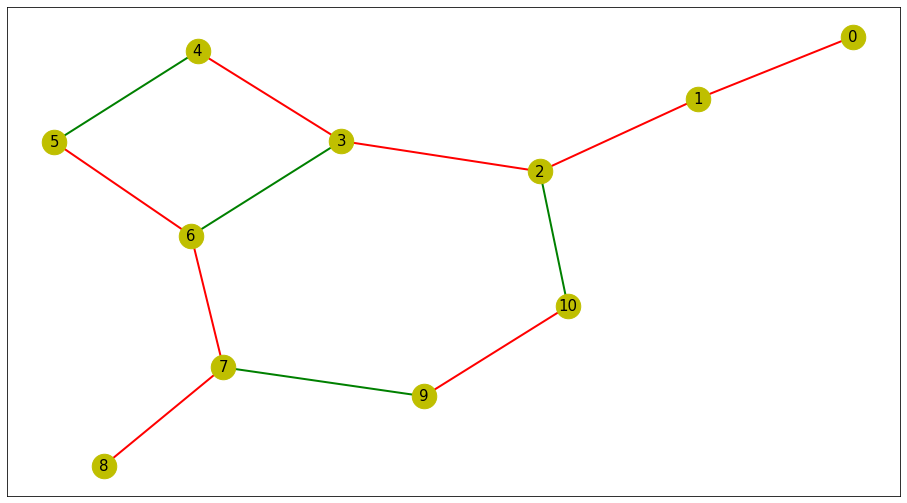

In [21]:
string = "@-45 d1S T2 @-135 b( a( t2( + ) ) c*( t1* + ) )"

dt1, dt2, dt3, dt4 = comprehend_string(string)
G = ds1_find_type_of_unpaired(dt1, dt3, dt4)
draw_skeleton(G)

0
0 : is unhinged
2
5
7
11
13
16
18
20
20 : is unhinged
24


C:\Users\peter\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\peter\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \


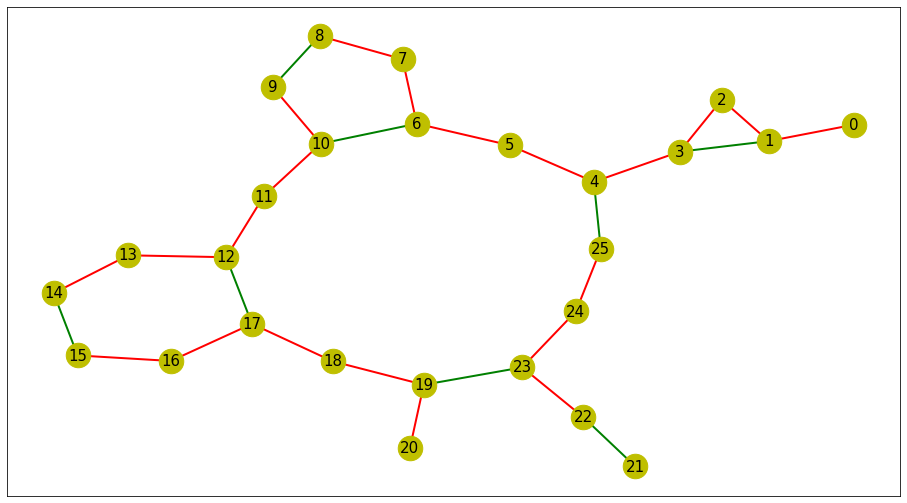

In [31]:
string = "a b( c ) d( e f( g h( + ) ) i j( k l( + ) m ) n o( p + q( + ) ) r )"

dt1, dt2, dt3, dt4 = comprehend_string(string)
G = ds1_find_type_of_unpaired(dt1, dt3, dt4)
draw_skeleton(G)

In [32]:
G.edges.data()

EdgeDataView([(0, 1, {'color': 'r'}), (1, 2, {'color': 'r'}), (1, 3, {'color': 'g'}), (2, 3, {'color': 'r'}), (3, 4, {'color': 'r'}), (4, 5, {'color': 'r'}), (4, 25, {'color': 'g'}), (5, 6, {'color': 'r'}), (6, 7, {'color': 'r'}), (6, 10, {'color': 'g'}), (7, 8, {'color': 'r'}), (8, 9, {'color': 'g'}), (9, 10, {'color': 'r'}), (10, 11, {'color': 'r'}), (11, 12, {'color': 'r'}), (12, 13, {'color': 'r'}), (12, 17, {'color': 'g'}), (13, 14, {'color': 'r'}), (14, 15, {'color': 'g'}), (15, 16, {'color': 'r'}), (16, 17, {'color': 'r'}), (17, 18, {'color': 'r'}), (18, 19, {'color': 'r'}), (19, 20, {'color': 'r'}), (19, 23, {'color': 'g'}), (22, 23, {'color': 'r'}), (22, 21, {'color': 'g'}), (23, 24, {'color': 'r'}), (24, 25, {'color': 'r'})])

In [33]:
[n for n in G.edges.data(nbunch=8)]

[(8, 7, {'color': 'r'}), (8, 9, {'color': 'g'})]

In [64]:
tt = [n for n in G.edges(nbunch=8)]
type(tt[0])

tuple

In [66]:
if (8, 9) in [(8, 7), (9, 8)]:
    print("y")

In [40]:
#more verbose?
edge_of_8 = [n for n in G.edges.data(nbunch=8)]
if edge_of_8[0][2]['color'] is 'r':
    print("yea")
else:
    print("nah")

nah


In [46]:
[n for n in G.neighbors(10)]

[9, 11, 6]

2. Given angles determine the side for the substructure they are in. Using this, the whole column can be filled around the given info, if not provided, default is negative (-1) side.
3. complete angle/length col  
4. calculate  coords

In [ ]:
def ds2_fill_side_col(array, dictionary, list_of_lists):
    dom_count = len(list_of_lists)
    
    #complete side col ~ get same side for paireds/hairpins, default to -1
    curr_side = -1
    for dom in range(dom_count):

        if dom in dictionary:
            if array[dom, 1] != 0:
                segside = array[dom, 1]
            elif array[dictionary[dom], 1] != 0:
                segside = array[dictionary[dom], 1]
            else:
                segside = curr_side
            
            #if hairpin
            if dom == dictionary[dom]-2:
                array[dom, 1] = segside
                array[dom+1, 1] = segside
                array[dom+2, 1] = segside
            
            #if not hairpin
            else:
                array[dom, 1] = segside
                array[dictionary[dom], 1] = segside
            
        else:
            if array[dom, 1] == 0:
                array[dom, 1] = curr_side
        
        curr_side = array[dom, 1] #update curr side after changes
        
    return array, list_of_lists

In [ ]:
array, dictionary, list_of_lists = comprehend_string(string)
determine_structure(array, dictionary, list_of_lists)

In [ ]:
str4 = "@-90 a( b ) @-90 c @90 d( e ) @90 f"
array, dictionary, list_of_lists = comprehend_string(str4)
determine_structure(array, dictionary, list_of_lists)